# **Measuring Bias in clustering**


This notebook is a tutorial on auditing bias within a clustering task. We will use the _holisticai_ library throughout, introducing some of the functions we have created to help study algorithmic bias.

The sections are organised as follows :

1. Load the data : we load the adult dataset as a pandas DataFrame
2. Data Exploration : some preliminary analysis of the data
3. Pre-Processing and Train a Model : we train a kmeans model (sklearn)
4. Measure Bias : we compute a few bias metrics, and comment on their meaning

## **Load the data**

First of all, we need to import the required packages to perform our bias analysis and mitigation. You will need to have the `holisticai` package installed on your system, remember that you can install it by running: 
```bash
!pip install holisticai[all]
```

In [1]:
# Imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

We will start by importing the adult dataset, which we host on our library. The adult dataset contains a set of informations extract from US 1994 Census database. It includes personal information about the individuals, specifically sex, race, and education. In this tutorial we will perform unsupervised learning to cluster the data, then measure whether this clustering contains gender or race information (clustering bias).

In [2]:
from holisticai.datasets import load_dataset
df, group_a, group_b = load_dataset(dataset='adult', preprocessed=True, as_array=False)
df

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,class
0,25.0,226802.0,7.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,38.0,89814.0,9.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,28.0,336951.0,12.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,44.0,160323.0,10.0,7688.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,18.0,103497.0,10.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47980,27.0,257302.0,12.0,0.0,0.0,38.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
47981,40.0,154374.0,9.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
47982,58.0,151910.0,9.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
47983,22.0,201490.0,9.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## **Data Exploration**

In [3]:
# import holisticai charts
from holisticai.plots.bias import group_pie_plot
from holisticai.plots.bias import histogram_plot

<Axes: >

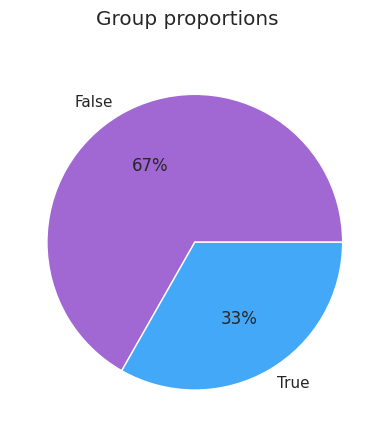

In [4]:
# pie plot of the Sex column
group_pie_plot(group_a)

<Axes: >

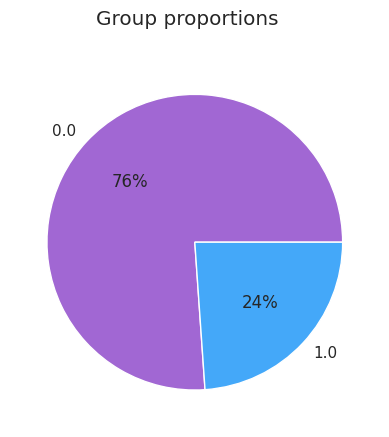

In [5]:
# pie plot of class column
p_attr = df['class']
group_pie_plot(p_attr)

<Axes: xlabel='sex', ylabel='Probability'>

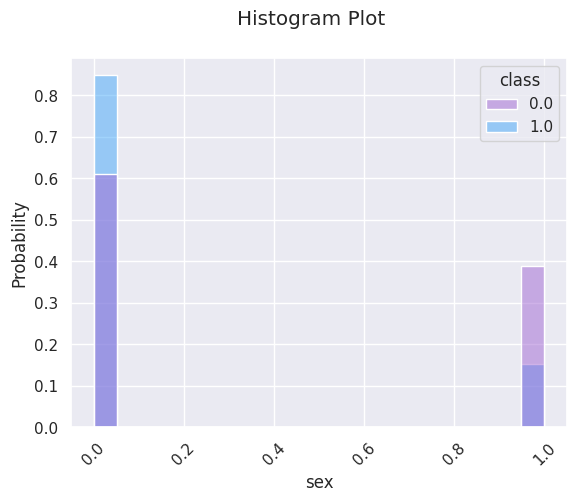

In [6]:
# Histogram of sex with class as hue
histogram_plot(group_a, df['class'])

## **Preprocess data and Train a model**

In [8]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [9]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

data = [X, y, group_a, group_b]

# Train test split
dataset = train_test_split(*data, test_size=0.2, shuffle=True)
train_data = dataset[::2]
test_data = dataset[1::2]

In [10]:
from sklearn.cluster import KMeans

ks = range(1, 8)
inertias = []
X_train, _, group_a_train, group_b_train = train_data

for k in ks:
    # create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # fit model to samples
    model.fit(X_train)
    
    # append the inertia to the list of inertias
    inertias.append(model.inertia_)

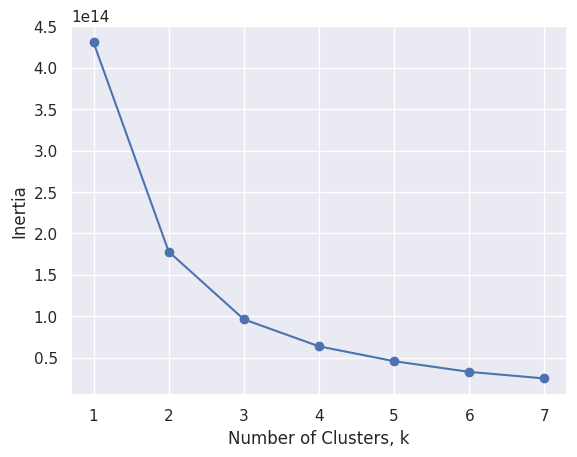

In [11]:
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [12]:
# we choose to use 4 clusters
model = KMeans(n_clusters = 4)
model.fit(X_train)

# test data
X, _, group_a, group_b = test_data

# predict
y_pred = model.predict(X)

## **Measure bias**

In [13]:
# imports
from holisticai.plots.bias import frequency_matrix_plot
from holisticai.metrics.bias import cluster_balance
from holisticai.metrics.bias import min_cluster_ratio

In [14]:
# set up vectors for measuring bias [we consider sex and race]
p_attr_sex = group_a.replace({"Male": 1, "Female": 0})
y_pred = model.predict(X)

<Axes: xlabel='Class', ylabel='Group'>

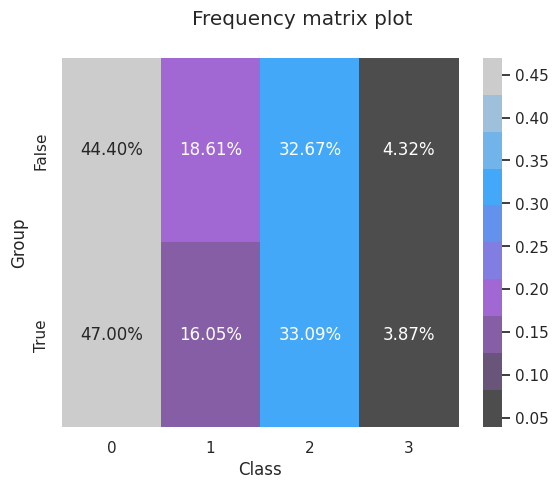

In [15]:
# probability for each gender and class
frequency_matrix_plot(p_attr_sex, y_pred, normalize='group')

The clustering is quite balanced in terms of gender representations.

In [17]:
cluster_balance(group_a, group_b, y_pred)

0.9043094735509389

The above metric reinforces the clustering is balanced in the sense of each group having similar representation in clusters to overall. The ideal value for this metric is 1.

### Batch computation

In [19]:
from holisticai.metrics.bias import clustering_bias_metrics

In [23]:
centroids = model.cluster_centers_
data = X

In [24]:
clustering_bias_metrics(group_a, group_b, y_pred, data = data, centroids = centroids, metric_type = 'equal_outcome')

,Value,Reference
Metric,,
Cluster Balance,0.904309,1
Minimum Cluster Ratio,0.437131,1
Cluster Distribution Total Variation,0.030041,0
Cluster Distribution KL Div,0.002852,0
Social Fairness Ratio,0.969357,1
Silhouette Difference,0.003731,0


The above metrics hint that the computed clustering **not** biased in terms of sex attribute.